In [72]:
import yaml

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 

from Toy_ML import MLModel, poly_fit
from data_plotting import ArcticPlotter, OxygenIsotopePlots
from netcdf_climate_analysis_funcs import climdata, multiplot, climatology
from glomar_gridding.grid import map_to_grid, grid_from_resolution

with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)


## 1. The Data

### 1.1. Load the data

#### 1.1.1. GloDAP

In [2]:
# Name of columns
latitude_field = "Latitude [degrees North]"
longitude_field = "Longitude [degrees East]"
temperature_field = "TEMPERATURE [DEG C]"
salinity_field = "SALNTY [PSS-78]"
depth_field = "DEPTH [M]"
oxygen_iso_field = "O18/O16 [/MILLE]"
reference_field = "Sample ID:INTEGER"
dt_format = "yyyy-mm-ddThh:mm:ss.sss"


In [3]:
# --- Load CSV ---
df = pd.read_csv(CONFIG["glodap"])

# --- Clean data ---
# Replace missing or placeholder values (like '**') with NaN
df = df.replace("**", np.nan)
df_qcd = df.dropna(subset=[longitude_field, latitude_field, salinity_field, oxygen_iso_field,temperature_field])


In [4]:
# Convert columns to numeric if necessary
df_qcd[longitude_field] = pd.to_numeric(df_qcd[longitude_field])
df_qcd[latitude_field] = pd.to_numeric(df_qcd[latitude_field])
df_qcd[salinity_field] = pd.to_numeric(df_qcd[salinity_field])
df_qcd[oxygen_iso_field] = pd.to_numeric(df_qcd[oxygen_iso_field])

df_qcd["datetime"] = pd.to_datetime(df_qcd[dt_format])
df_qcd = df_qcd.drop(columns=dt_format)


#### 1.1.2. BAS Pre-alpha

In [5]:
# Name of columns
latitude_field = "Latitude"
longitude_field = "Longitude"
temperature_field = "Temperature [C]"
salinity_field = "CTD Salinity"
depth_field = "Sample Depth (m)"
pressure_field = "CTD Pressure [dbar]"
oxygen_iso_field = "DELO18 [‰]"
reference_field = "Dataset"
dt_format = "Date"

In [6]:
# --- Load CSV ---
df_inp = pd.read_csv(CONFIG["BAS_prealpha"])

# --- QC data ---
# Replace missing or placeholder values (like '**') with NaN
df = df_inp.replace(["-","**"], np.nan)

# Convert columns to numeric
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[temperature_field] = pd.to_numeric(df[temperature_field])
df[depth_field] = pd.to_numeric(df[depth_field])
df[pressure_field] = pd.to_numeric(df[pressure_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format], format="mixed")
df = df.drop(columns=dt_format)

# Convert outlandish values to NaN
df[longitude_field] = df.where(df[longitude_field] < 180, np.nan)[longitude_field]
df[salinity_field] = df.where(df[salinity_field] > 10, np.nan)[salinity_field]
df[oxygen_iso_field] = df.where((df[oxygen_iso_field] > -10) & (df[oxygen_iso_field] < 10), np.nan)[oxygen_iso_field]
df[temperature_field] = df.where((df[temperature_field] > -5) & (df[temperature_field] < 50), np.nan)[temperature_field]
df[pressure_field] = df.where(df[pressure_field] < 180, np.nan)[pressure_field]
df[depth_field] = df.where(df[depth_field] >-1, np.nan)[depth_field]

# Drop QCd values
df_qcd = df.dropna(subset=[longitude_field, 
                       latitude_field, 
                       salinity_field, 
                       oxygen_iso_field, 
                       temperature_field,
                       # depth_field,
                       # pressure_field
                       ])
print(f"The original dataset has {df_inp.shape[0]} rows.")
print(f"After applying QC, the dataset has {df.shape[0]} rows.")


/tmp/ipykernel_2957390/189698850.py:2: DtypeWarning: Columns (2,11,16,17,18,20,22,23,25,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inp = pd.read_csv(CONFIG["BAS_prealpha"])


The original dataset has 89039 rows.
After applying QC, the dataset has 89039 rows.


#### 1.1.3. Arctic Ocean Reanalysis

In [7]:
# Load in model data
aor = climdata(CONFIG["arctic_reanalysis"])

sal_aor = aor.so
temp_aor = aor.thetao

### 1.2. What does the data look like? 

#### 1.2.1. Spatial plots

First let us consider the spatial sampling of the data. 

We see that there is quite a spread across the Arctic region.
* In the 1980s, most of the data is confined to the ~0E
* In the late 2010s, the data is around the pole
* Between these dates, the data is more spread

In [10]:
# Call class
arcticplot = ArcticPlotter(df_qcd[latitude_field], df_qcd[longitude_field])

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

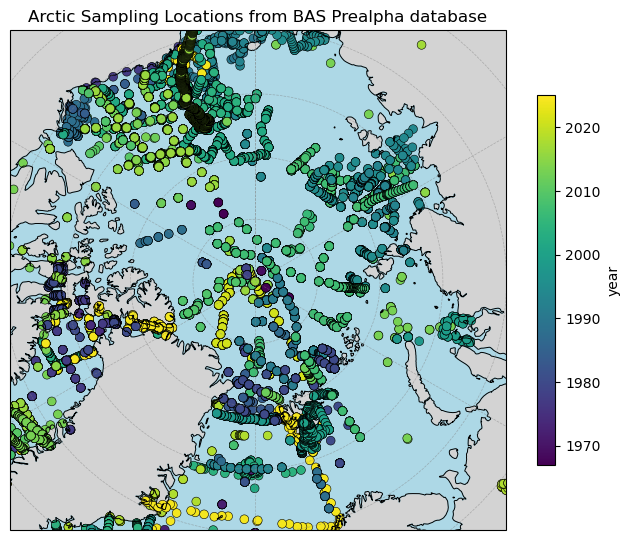

In [11]:
# Plot by year
arcticplot.title = "Arctic Sampling Locations from BAS Prealpha database"
arcticplot.plot(cbar_data=df_qcd["datetime"].dt.year)

A fundamental problem with this dataset is that there isn't enough data to be able to train the model on a regional basis, which we suggest will have a substantial influence on the oxygen isotopes. Unfortunately, there isn't a clear pattern in salinity, temperature or depth that would point to specific locations, as seen below

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

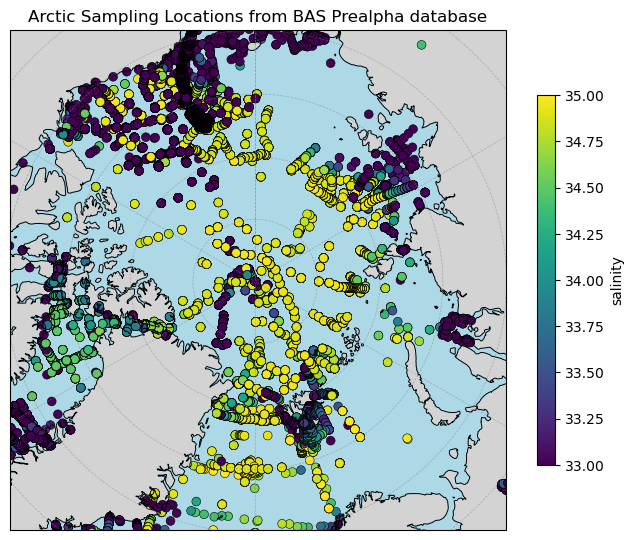

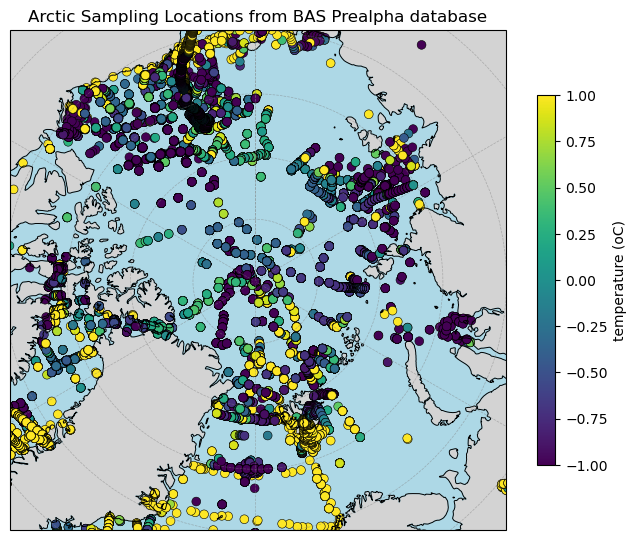

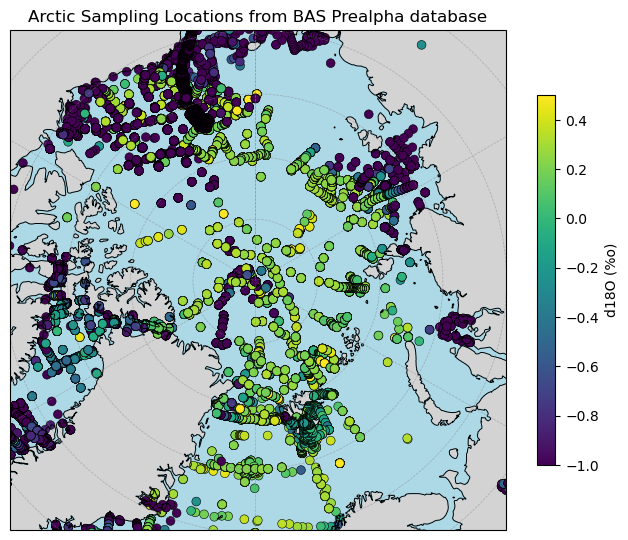

In [13]:
# Plot salinity over space
arcticplot.cbar_title = "salinity"
arcticplot.plot(cbar_data=df_qcd[salinity_field], vmin=33, vmax=35)

# Plot temperature over space
arcticplot.cbar_title = "temperature (oC)"
arcticplot.plot(cbar_data=df_qcd[temperature_field], vmin=-1, vmax=1)

# Plot pressure over space
# arcticplot.cbar_title = "pressure (dbar)"
# arcticplot.plot(cbar_data=df_qcd[pressure_field], vmin=0, vmax=500)

# Plot oxygen isotope over space
arcticplot.cbar_title = "d18O (%o)"
arcticplot.plot(cbar_data=df_qcd[oxygen_iso_field], vmin=-1, vmax=0.5)


#### 1.2.2. δ¹⁸O plots

Now, let's consider the relationship between δ¹⁸O and temperature, salinity & depth. 

We can see that the strongest trend is in the salinity data. Temperature and depth are largely constant with δ¹⁸O except close to the origin (-2oC & 0m).

In [154]:
# Call class
d18o_plot = OxygenIsotopePlots(x=salinity_field, y=oxygen_iso_field, ref=reference_field)

# --- Scatter plot: d18O vs. Salinity ---
fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Salinity ---
d18o_plot.x = temperature_field
d18o_plot.title = "δ¹⁸O vs. Temperature from BAS Prealpha database"
d18o_plot.x_title = "temperature (oC)"

fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Pressure ---
d18o_plot.x = pressure_field
d18o_plot.title = "δ¹⁸O vs. Pressure from BAS Prealpha database"
d18o_plot.x_title = "pressure (dbar)"

fig = d18o_plot.plot(df)
fig.show()

#### 1.2.3. AOR Plots

Now, we want to have a look at the AOR data and how it compares to the in-situ

In [24]:
# Select a month to compare the data with the model
mo, yr = 9, 2016
df_1month = df_qcd[(df_qcd["datetime"].dt.year == yr) & (df_qcd["datetime"].dt.month == mo)]

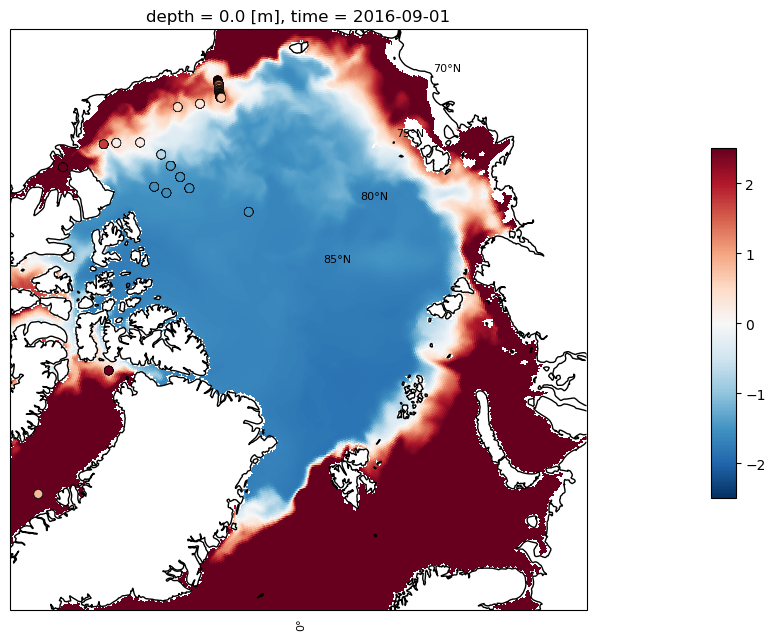

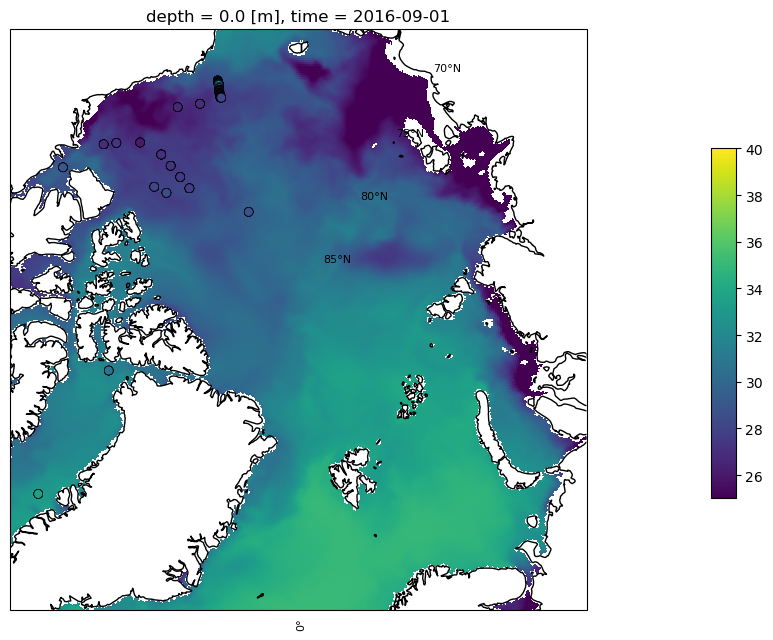

In [31]:
fig, ax, p = multiplot(temp_aor.sel(time=f"{yr}-{mo}-01"), vmin=-2.5, vmax=2.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

# --- Plot the sample points ---
arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field] 
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[temperature_field], vmin=-2.5, vmax=2.5, cmap="RdBu_r")
# sc = ax.scatter(
#     df_1month[longitude_field],
#     df_1month[latitude_field],
#     c=df_1month[temperature_field],
#     s=40,
#     cmap="RdBu_r",
#     transform=ccrs.PlateCarree(),
#     edgecolor="black",
#     linewidth=0.4,
#     vmin=-2.5,
#     vmax=2.5,
# )

fig, ax, p = multiplot(sal_aor.sel(time=f"{yr}-{mo}-01"), vmin=25, vmax=40, cmap="viridis", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[salinity_field], vmin=25, vmax=40)
# # --- Plot the sample points ---
# sc = ax.scatter(
#     df201609[longitude_field],
#     df201609[latitude_field],
#     c=df201609[salinity_field],
#     s=40,
#     cmap="viridis",
#     transform=ccrs.PlateCarree(),
#     edgecolor="black",
#     linewidth=0.4,
#     vmin=25,
#     vmax=40,
# )

### 1.3. Seasonality & annual variation

Let's start by considering how many data points are in each month. We can see that the vast majority are in October & September, with very few in May and July.

In [39]:
# Count the number of observations in each month of a year
df_qcd["datetime"].dt.month.value_counts().sort_index()

datetime
1     2800
2     2026
3     1769
4     1329
5     2130
6     3212
7     7022
8     7845
9     8992
10    4518
11    1394
12    1657
Name: count, dtype: int64

To test this, we create a dataset that removes the summer months (May & July)

In [40]:
df_nosummer = df_qcd[df_qcd['datetime'].dt.month.isin([7, 8, 9, 10])] # Drop summer months

## 2. Train the model

Here, we train the model with 90% of the data and then apply the training to the final 10%. We then infer the error based on the difference between the model and the actual values in the final 10%. We use:
* RMSE: Higher RMSE means worse agreement
* R2: Closer to 0 means worse fit
* Absolute error percentiles (5th, 25th, 50th, 75th, 95th): Higher values in higher percentiles means the error is focused there

### 2.1. Train the model on all the data

First thing to do is train the model on all the data. For the BAS pre-alpha, I'll use longitude, latitude, salinity temperature: there are too few values in the pressure/depth fields to add value.

In [32]:
# Create the 90% for training & 10% for inference
df_10 = df_qcd.sample(frac=0.10)  # 10% sample
df_90 = df_qcd.drop(df_10.index)  # get rest

(array([484., 170., 141., 217., 326., 757., 781., 855., 456., 282.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

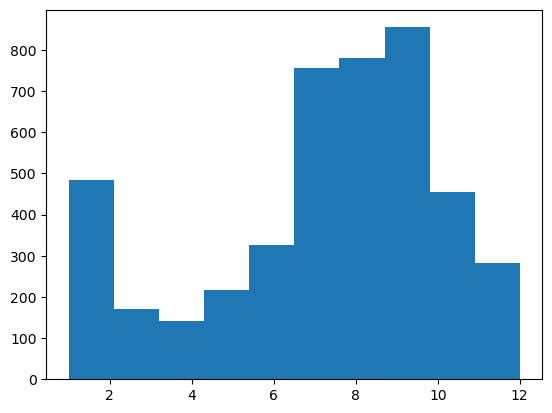

In [ ]:
# Add a plot of distribution across the months for 10% as a check
plt.hist(df_10['datetime'].dt.month)

In [35]:
# Call the ML model
ml_model = MLModel(df_90, df_10, [salinity_field, temperature_field, longitude_field, latitude_field], oxygen_iso_field)
# Training
trained_model = ml_model.training()
# Inference
model_test = ml_model.inference(trained_model[1], trained_model[0])

ML Predicted Oxygen RMSE: 0.3786476437156177
ML Predicted Oxygen R2: 0.9096487343606571
ML Predicted Oxygen Error Percentiles [0.00730451 0.03868271 0.09466766 0.27053718 0.8956825 ]


d18O is somewhere between -1 & 1 so these errors seem ok? Certainly, they are better than a polynomial fit as seen below

In [36]:
poly_test = poly_fit(df_90, 
         df_10, 
         salinity_field,
         oxygen_iso_field,
         create_plot=False
         )

Poly Predicted Oxygen RMSE: 0.6303492198705174
Poly Predicted Oxygen R2: 0.7234508156165302
Poly Predicted Oxygen Error Percentiles [0.0233006  0.10235913 0.22348222 0.58365759 1.39836409]


In [37]:
print("Different fits to models")
print(f"RMSE: ML {model_test[1]} v polynomial {poly_test[1]}")
print(f"R2: full {model_test[2]} v polynomial {poly_test[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v polynomial {np.percentile(poly_test[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: ML 0.3786476437156177 v polynomial 0.6303492198705174
R2: full 0.9096487343606571 v polynomial 0.7234508156165302
Error Percentiles: full [0.00730451 0.03868271 0.09466766 0.27053718 0.8956825 ] v polynomial [0.0233006  0.10235913 0.22348222 0.58365759 1.39836409]


### 2.2. Train the model after detrending

We can use the AOR model to detrend the data, meaning we won't have interannual variability baked in. Note that there will be interannual variability in the oxygen tracer (as we don't have model data for that) on which the model is trained.

In [55]:
# Create an AOR climatology
sal_aor_clim_da = climatology(sal_aor.drop("depth"), tstep='month')
sal_aor_clim = sal_aor_clim_da.to_dataframe(name="so").dropna().reset_index()

temp_aor_clim_da = climatology(temp_aor.drop("depth"), tstep='month')
temp_aor_clim = temp_aor_clim_da.to_dataframe(name="thetao").dropna().reset_index()

aor_clim = pd.merge(sal_aor_clim, temp_aor_clim, on=["month", "depth", "latitude", "longitude"])


/tmp/ipykernel_2957390/1241893370.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  sal_aor_clim_da = climatology(sal_aor.drop("depth"), tstep='month')
/tmp/ipykernel_2957390/1241893370.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  temp_aor_clim_da = climatology(temp_aor.drop("depth"), tstep='month')


In [138]:
# Map the in-situ data to the AOR grid
grid = grid_from_resolution(0.125, bounds=[[-179.875, 180], [-89.875, 90]], coord_names=["longitude", "latitude"])

# Add grid coordinates 
df_gridd = map_to_grid(pl.from_pandas(df_qcd[["datetime", latitude_field, longitude_field, 
                                   salinity_field, temperature_field, oxygen_iso_field]]), 
                                   grid, obs_coords=[longitude_field, latitude_field], 
                                   grid_coords=["longitude", "latitude"]).to_pandas()

# Add a month column
df_gridd['month'] = df_gridd['datetime'].dt.month
df_gridd.rename(columns={"grid_Longitude": "longitude", "grid_Latitude": "latitude"}, inplace=True)

# Create anomaly by merging actual to climatology
df_anom = (
    df_gridd
    .merge(
        aor_clim,
        on=["month", "longitude", "latitude"],
        how="left",
    )
)

df_anom["temperature anomaly (oC)"] = df_anom[temperature_field] - df_anom["thetao"]
df_anom["salinity anomaly (pss)"] = df_anom[salinity_field] - df_anom["so"]
df_anom = df_anom[["datetime", 
                   longitude_field, 
                   latitude_field, 
                   temperature_field, 
                   salinity_field, 
                   oxygen_iso_field,
                   "temperature anomaly (oC)", 
                   "salinity anomaly (pss)"]
                   ].dropna()

In [132]:
## Finally, train the model on the anomalies
df_anom_10 = df_anom.sample(frac=0.10) 
df_anom_90 = df_anom.drop(df_anom_10.index)

# Call the ML model
ml_model = MLModel(df_anom_90, df_anom_10, [salinity_field, temperature_field, longitude_field, latitude_field], oxygen_iso_field)
# Training
trained_model = ml_model.training()
# Inference
model_test = ml_model.inference(trained_model[1], trained_model[0])

ML Predicted Oxygen RMSE: 0.406022844758006
ML Predicted Oxygen R2: 0.9005661897645894
ML Predicted Oxygen Error Percentiles [0.00854957 0.04225649 0.10508593 0.27351319 0.86657361]


So this doesn't improve the model; indeed it makes it slightly worse, but not by much. However, it does detrend it which means that we are accounting for interannual variability in the data. 

Note that we remove another 10000 data points by subtracting the climatology. I suspect that these are on-land points (as the AOR doesn't have these), so this is useful QC!

### 2.3. Train the model without summer

First thing to do is train the model on all the data

In [161]:
# Create the 90% for training & 10% for inference
df_10_nosumm = df_nosummer.sample(frac=0.10)  # 10% sample
df_90_nosumm = df_nosummer.drop(df_10_nosumm.index)  # get rest

In [162]:
# Change input to exclude summer months
ml_model.df_10 = df_10_nosumm
ml_model.df_90 = df_90_nosumm

# Training
trained_model_nosumm = ml_model.training()
# Inference
model_test_nosumm = ml_model.inference(trained_model_nosumm[1], trained_model_nosumm[0],)

ML Predicted Oxygen RMSE: 0.3482443884389936
ML Predicted Oxygen R2: 0.9038389388257473
ML Predicted Oxygen Error Percentiles [0.0068225  0.03707769 0.09317224 0.20309254 0.72470757]


In [163]:
print("Different fits to models")
print(f"RMSE: full {model_test[1]} v no-summer {model_test_nosumm[1]}")
print(f"R2: full {model_test[2]} v no-summer {model_test_nosumm[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v no-summer {np.percentile(model_test_nosumm[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: full 0.28082873178837603 v no-summer 0.3482443884389936
R2: full 0.9299335082918543 v no-summer 0.9038389388257473
Error Percentiles: full [0.0068137  0.03531894 0.08214365 0.18517043 0.55514382] v no-summer [0.0068225  0.03707769 0.09317224 0.20309254 0.72470757]


Removing the summer months reduces the RMSE and increases the R2, suggesting that the model works better without them.

### 2.4. Train the model using different input variables

Now, let's consider how the ML model works if we use different input variables. The full model inputs salinity, temperature and depth. According to the plots in Sec. 1.2.2, salinity has the strongest relationship with d18O, so let's test that. Let's try:
* Salinity only
* Temperature only
* Pressure only
* Salinity & temperature
* Salinity & pressure

In [57]:
# First, we need to QC the data depending on which variables we are using
var_dic = {"S": [salinity_field, longitude_field, latitude_field],
           "T": [temperature_field, longitude_field, latitude_field],
           "P": [pressure_field, longitude_field, latitude_field],
           "ST": [salinity_field, temperature_field, longitude_field, latitude_field],
           "TP": [temperature_field, pressure_field, longitude_field, latitude_field],
           "SP": [salinity_field, pressure_field, longitude_field, latitude_field],
           "STP": [salinity_field, temperature_field, pressure_field, longitude_field, latitude_field]
}

df_qc_dic = {"S": df.dropna(subset=[*var_dic["S"], oxygen_iso_field]),
             "T": df.dropna(subset=[*var_dic["T"], oxygen_iso_field]),
             "P": df.dropna(subset=[*var_dic["P"], oxygen_iso_field]),
              "ST": df.dropna(subset=[*var_dic["ST"], oxygen_iso_field]),
              "TP": df.dropna(subset=[*var_dic["TP"], oxygen_iso_field]),
              "SP": df.dropna(subset=[*var_dic["SP"], oxygen_iso_field]),
              "STP": df.dropna(subset=[*var_dic["STP"], oxygen_iso_field])
}

# Then we create the 90% and 10%
df_10_dic = {key: df_qc_dic[key].sample(frac=0.10) for key in df_qc_dic.keys()}
df_90_dic = {key: df_qc_dic[key].drop(df_10_dic[key].index) for key in df_qc_dic.keys()}

# Train the model for the different variable combinations
model_dic = {key: MLModel(df_90_dic[key], df_10_dic[key], 
                                 input_cols=var_dic[key], 
                                 target_col=oxygen_iso_field) for key in df_qc_dic.keys()}

trained_dic = {key: model_dic[key].training() for key in df_qc_dic.keys()}
model_test_dic = {key: model_dic[key].inference(trained_dic[key][1], trained_dic[key][0]) for key in df_qc_dic.keys()}


ML Predicted Oxygen RMSE: 0.4520192073542277
ML Predicted Oxygen R2: 0.8820785592698471
ML Predicted Oxygen Error Percentiles [0.0093186  0.04607846 0.12700762 0.32059464 0.952639  ]
ML Predicted Oxygen RMSE: 0.7429113921711817
ML Predicted Oxygen R2: 0.4745500109651606
ML Predicted Oxygen Error Percentiles [0.01976931 0.10700322 0.27849428 0.66716783 1.56926401]
ML Predicted Oxygen RMSE: 0.5543159292319988
ML Predicted Oxygen R2: 0.7559225997929364
ML Predicted Oxygen Error Percentiles [0.01559254 0.08109319 0.20303633 0.43233644 0.9717949 ]
ML Predicted Oxygen RMSE: 0.3775220994556127
ML Predicted Oxygen R2: 0.9120506615231373
ML Predicted Oxygen Error Percentiles [0.00644441 0.03554381 0.09274617 0.26127709 0.91443509]
ML Predicted Oxygen RMSE: 0.43548621654103614
ML Predicted Oxygen R2: 0.8489381567019152
ML Predicted Oxygen Error Percentiles [0.01378149 0.06342842 0.16987259 0.35490304 0.85177173]
ML Predicted Oxygen RMSE: 0.2782291612774394
ML Predicted Oxygen R2: 0.9454339351816

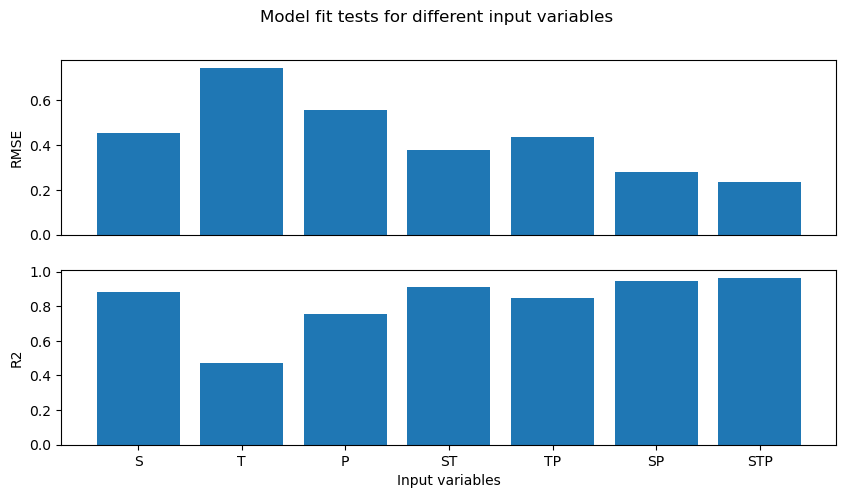

In [59]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
yname = ["RMSE", "R2"]

fig.suptitle("Model fit tests for different input variables")

for i, ax in enumerate(axs):
    ax.bar(list(model_dic.keys()), [mt[i + 1] for mt in model_test_dic.values()])
    ax.set_ylabel(yname[i])
    ax.set_xlabel("Input variables")
    if i<len(axs)-1:
        ax.set_xticks([])
        ax.set_xlabel("")
        

It is clear that salinity is the most important variable in the model. If we don't use it, the error blows up significantly. Indeed, we see that while it is better to include all the variables, salinity does a reasonable job on its own. 

Note that pressure/depth levels seem more important than temperature, but that may be due to there being less data available after QCing the pressure.

In [60]:
print(f"RMSE: all variables {model_test_dic["STP"][1]} v salinity only {model_test_dic["S"][1]}")
print(f"R2: all variables {model_test_dic["STP"][2]} v salinity only {model_test_dic["S"][2]}")

RMSE: all variables 0.23281082651312696 v salinity only 0.4520192073542277
R2: all variables 0.9625848068708688 v salinity only 0.8820785592698471


## 3. Arctic Ocean Reanalysis

Now that we have trained our model, we can apply it the Arctic Ocean Reanalysis. This contains temperature and salinity: now we can add our oxygen isotope tracer!

### 3.1. Load AOR data